# Power integrity analysis
This example shows how to use the Ansys Electronics Database (EDB) for power integrity analysis. The
EDB is loaded into HFSS 3D Layout for analysis and postprocessing.

- Set up EDB consists of these steps:

    - Assign S-parameter model to components.
    - Create pin groups.
    - Create ports.
    - Create SIwave SYZ analysis.
    - Create cutout.

- Import EDB into HFSS 3D Layout:

    - Analyze.
    - Plot ``$Z_{11}$``.

Keywords: **HFSS 3D Layout**, **power integrity**.

## Perform imports and define constants
Import the required packages

In [1]:
import json
import os
import tempfile
import time

import ansys.aedt.core
from ansys.aedt.core.examples.downloads import download_file

Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

Download the example PCB data.

In [4]:
aedb = download_file(source="edb/ANSYS-HSD_V1.aedb", local_path=temp_folder.name)
_ = download_file(
    source="touchstone",
    name="GRM32_DC0V_25degC_series.s2p",
    local_path=temp_folder.name,
)

## Create configuration file
This example uses a configuration file to set up the layout for analysis.
Initialize and create an empty dictionary to host all configurations.

In [5]:
cfg = dict()

Assigns S-parameter models to capacitors.
The first step is to use the "general" key to specify where the S-parameter files can be found.

In [6]:
cfg["general"] = {"s_parameter_library": os.path.join(temp_folder.name, "touchstone")}

## Assign model to capactitors
The model ``GRM32_DC0V_25degC_series.s2p`` is assigned to capacitors C3 and C4, which share the same component part number.
When "apply_to_all" is ``True``, all components having the part number "CAPC3216X180X20ML20" are assigned the S-parameter model.

In [7]:
cfg["s_parameters"] = [
    {
        "name": "GRM32_DC0V_25degC_series",
        "component_definition": "CAPC0603X33X15LL03T05",
        "file_path": "GRM32_DC0V_25degC_series.s2p",
        "apply_to_all": False,
        "components": ["C110", "C206"],
        "reference_net": "GND",
        "reference_net_per_component": {"C110": "GND"},
    }
]

## Create pin groups
Pins can be grouped explicitly by the pin name, or pin groups can be assigned by net name using the ''net'' key.
The following code combine the listed pins on component U2 into two pin groups using the ``net`` key.

In [8]:
cfg["pin_groups"] = [
    {
        "name": "PIN_GROUP_1",
        "reference_designator": "U1",
        "pins": ["AD14", "AD15", "AD16", "AD17"],
    },
    {"name": "PIN_GROUP_2", "reference_designator": "U1", "net": "GND"},
]

## Create ports
Create a circuit port between the two pin groups just created.

In [9]:
cfg["ports"] = [
    {
        "name": "port1",
        "reference_designator": "U1",
        "type": "circuit",
        "positive_terminal": {"pin_group": "PIN_GROUP_1"},
        "negative_terminal": {"pin_group": "PIN_GROUP_2"},
    }
]

## Create SIwave SYZ analysis setup
Both SIwave and HFSS can be used to run an analysis in the 3D Layout user interface.

In [10]:
cfg["setups"] = [
    {
        "name": "siwave_syz",
        "type": "siwave_syz",
        "pi_slider_position": 1,
        "freq_sweep": [
            {
                "name": "Sweep1",
                "type": "Interpolation",
                "frequencies": [
                    {
                        "distribution": "log scale",
                        "start": 1e6,
                        "stop": 1e9,
                        "samples": 20,
                    }
                ],
            }
        ],
    }
]

## Define cutout
Define the region of the PCB to be cut out for analysis.

In [11]:
cfg["operations"] = {
    "cutout": {
        "signal_list": ["1V0"],
        "reference_list": ["GND"],
        "extent_type": "ConvexHull",
        "expansion_size": 0.002,
        "use_round_corner": False,
        "output_aedb_path": "",
        "open_cutout_at_end": True,
        "use_pyaedt_cutout": True,
        "number_of_threads": 4,
        "use_pyaedt_extent_computing": True,
        "extent_defeature": 0,
        "remove_single_pin_components": False,
        "custom_extent": "",
        "custom_extent_units": "mm",
        "include_partial_instances": False,
        "keep_voids": True,
        "check_terminals": False,
        "include_pingroups": False,
        "expansion_factor": 0,
        "maximum_iterations": 10,
        "preserve_components_with_model": False,
        "simple_pad_check": True,
        "keep_lines_as_path": False,
    }
}

## Save configuration

Save the configuration file to a JSON file and apply it to layout data using the EDB.

In [12]:
pi_json = os.path.join(temp_folder.name, "pi.json")
with open(pi_json, "w") as f:
    json.dump(cfg, f, indent=4, ensure_ascii=False)

## Load configuration into EDB

Load the configuration into EDB from the JSON file.

In [13]:
edbapp = ansys.aedt.core.Edb(aedb, edbversion=AEDT_VERSION)
edbapp.configuration.load(config_file=pi_json)
edbapp.configuration.run()
edbapp.save()
edbapp.close()

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `edbversion` is deprecated for method `Edb`; use `version` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Star initializing Edb 05:31:46.379383


INFO:Edb:Star initializing Edb 05:31:46.379383


PyEDB INFO: Edb version 2025.2


INFO:Edb:Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


INFO:Edb:Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.61.0


INFO:Edb:legacy v0.61.0


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


INFO:Edb:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


INFO:Edb:Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


INFO:Edb:Cell main Opened


PyEDB INFO: Builder was initialized.


INFO:Edb:Builder was initialized.


PyEDB INFO: open_edb completed in 9.0889 seconds.


INFO:Edb:open_edb completed in 9.0889 seconds.


PyEDB INFO: EDB initialization completed in 9.1683 seconds.


INFO:Edb:EDB initialization completed in 9.1683 seconds.


PyEDB INFO: Updating boundaries finished. Time lapse 0:00:00.015755


INFO:Edb:Updating boundaries finished. Time lapse 0:00:00.015755


PyEDB INFO: Updating nets finished. Time lapse 0:00:00


INFO:Edb:Updating nets finished. Time lapse 0:00:00


PyEDB INFO: Updating components finished. Time lapse 0:00:00


INFO:Edb:Updating components finished. Time lapse 0:00:00


PyEDB INFO: Creating pin groups finished. Time lapse 0:00:00.649001


INFO:Edb:Creating pin groups finished. Time lapse 0:00:00.649001


PyEDB INFO: Placing sources finished. Time lapse 0:00:00


INFO:Edb:Placing sources finished. Time lapse 0:00:00


PyEDB INFO: Applying materials finished. Time lapse 0:00:00


INFO:Edb:Applying materials finished. Time lapse 0:00:00


PyEDB INFO: Updating stackup finished. Time lapse 0:00:00


INFO:Edb:Updating stackup finished. Time lapse 0:00:00


PyEDB INFO: Applying padstacks finished. Time lapse 0:00:00


INFO:Edb:Applying padstacks finished. Time lapse 0:00:00


PyEDB INFO: Applying S-parameters finished. Time lapse 0:00:00.015741


INFO:Edb:Applying S-parameters finished. Time lapse 0:00:00.015741


PyEDB INFO: Applying package definitions finished. Time lapse 0:00:00


INFO:Edb:Applying package definitions finished. Time lapse 0:00:00


PyEDB INFO: Applying modeler finished. Time lapse 0:00:00


INFO:Edb:Applying modeler finished. Time lapse 0:00:00


PyEDB INFO: Placing ports finished. Time lapse 0:00:00.016060


INFO:Edb:Placing ports finished. Time lapse 0:00:00.016060


PyEDB INFO: Placing terminals completed in 0.0000 seconds.


INFO:Edb:Placing terminals completed in 0.0000 seconds.


PyEDB INFO: Placing probes finished. Time lapse 0:00:00


INFO:Edb:Placing probes finished. Time lapse 0:00:00


PyEDB INFO: -----------------------------------------


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `signal_list` is deprecated for method `cutout`; use `signal_nets` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `reference_list` is deprecated for method `cutout`; use `reference_nets` instead.
  warnings.warn(
INFO:Edb:-----------------------------------------


PyEDB INFO: Trying cutout with (0.002)*(1000.0)mm expansion size


INFO:Edb:Trying cutout with (0.002)*(1000.0)mm expansion size


PyEDB INFO: -----------------------------------------


INFO:Edb:-----------------------------------------


PyEDB INFO: Cutout Multithread started.


INFO:Edb:Cutout Multithread started.


PyEDB INFO: Net clean up Elapsed time: 0m 1sec


INFO:Edb:Net clean up Elapsed time: 0m 1sec


PyEDB INFO: Extent Creation Elapsed time: 0m 0sec


INFO:Edb:Extent Creation Elapsed time: 0m 0sec


PyEDB INFO: 1310 Padstack Instances deleted. Elapsed time: 0m 1sec


INFO:Edb:1310 Padstack Instances deleted. Elapsed time: 0m 1sec


PyEDB INFO: 265 Primitives deleted. Elapsed time: 0m 2sec


INFO:Edb:265 Primitives deleted. Elapsed time: 0m 2sec


PyEDB INFO: 702 components deleted


INFO:Edb:702 components deleted


PyEDB INFO: Cutout completed. Elapsed time: 0m 4sec


INFO:Edb:Cutout completed. Elapsed time: 0m 4sec


PyEDB INFO: EDB file save completed in 0.0792 seconds.


INFO:Edb:EDB file save completed in 0.0792 seconds.


PyEDB INFO: Cutout completed in 1 iterations with expansion size of (0.002)*(1000.0)mm Elapsed time: 0m 5sec


INFO:Edb:Cutout completed in 1 iterations with expansion size of (0.002)*(1000.0)mm Elapsed time: 0m 5sec


PyEDB INFO: Applying operations completed in 4.5657 seconds.


INFO:Edb:Applying operations completed in 4.5657 seconds.


PyEDB INFO: Save Edb file completed in 0.0631 seconds.


INFO:Edb:Save Edb file completed in 0.0631 seconds.


PyEDB INFO: Close Edb file completed in 0.0789 seconds.


INFO:Edb:Close Edb file completed in 0.0789 seconds.


True

The configured EDB file is saved in the temporary folder.

In [14]:
print(temp_folder.name)

C:\Users\ansys\AppData\Local\Temp\tmp0irvava1.ansys


## Analyze in HFSS 3D Layout

### Load EDB into HFSS 3D Layout

In [15]:
h3d = ansys.aedt.core.Hfss3dLayout(
    aedb, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


INFO:Global:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.22.dev0.


INFO:Global:PyAEDT version 0.22.dev0.


PyAEDT INFO: Initializing new Desktop session.


INFO:Global:Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


INFO:Global:Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_3e449f4a-1fc7-4e5e-8238-700b79e22360.log is enabled.


INFO:Global:Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_3e449f4a-1fc7-4e5e-8238-700b79e22360.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


INFO:Global:Log on AEDT is disabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


INFO:Global:Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


INFO:Global:Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 57258.


INFO:Global:New AEDT session is starting on gRPC port 57258.


PyAEDT INFO: Electronics Desktop started on gRPC port: 57258 after 10.199898958206177 seconds.


INFO:Global:Electronics Desktop started on gRPC port: 57258 after 10.199898958206177 seconds.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


INFO:Global:AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Ansoft.ElectronicsDesktop.2025.2 version started with process ID 4384.


INFO:Global:Ansoft.ElectronicsDesktop.2025.2 version started with process ID 4384.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmp0irvava1.ansys\edb\ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


INFO:Global:EDB folder C:\Users\ansys\AppData\Local\Temp\tmp0irvava1.ansys\edb\ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


PyAEDT INFO: Active Design set to 0;main


INFO:Global:Active Design set to 0;main


PyAEDT INFO: Active Design set to 0;main


INFO:Global:Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


INFO:Global:Aedt Objects correctly read


### Analyze

In [16]:
h3d.analyze(cores=NUM_CORES)

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


INFO:Global:Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


INFO:Global:Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Solving all design setups. Analysis started...


INFO:Global:Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 40.0s


INFO:Global:Design setup None solved correctly in 0.0h 0.0m 40.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


INFO:Global:Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


True

### Plot impedance

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmp0irvava1.ansys\edb\ANSYS-HSD_V1.aedt.


INFO:Global:Parsing C:\Users\ansys\AppData\Local\Temp\tmp0irvava1.ansys\edb\ANSYS-HSD_V1.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmp0irvava1.ansys\edb\ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


INFO:Global:File C:\Users\ansys\AppData\Local\Temp\tmp0irvava1.ansys\edb\ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.29680776596069336


INFO:Global:aedt file load time 0.29680776596069336


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


INFO:Global:PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Loading Modeler.


INFO:Global:Loading Modeler.


PyAEDT INFO: Modeler loaded.


INFO:Global:Modeler loaded.


PyAEDT INFO: EDB loaded.


INFO:Global:EDB loaded.


PyAEDT INFO: Layers loaded.


INFO:Global:Layers loaded.


PyAEDT INFO: Primitives loaded.


INFO:Global:Primitives loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Modeler class has been initialized! Elapsed time: 0m 0sec


PyEDB INFO: Star initializing Edb 05:33:10.748905


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)
INFO:Edb:Star initializing Edb 05:33:10.748905


PyEDB INFO: Edb version 2025.2


INFO:Edb:Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


INFO:Edb:Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.61.0


INFO:Edb:legacy v0.61.0


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


INFO:Edb:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


INFO:Edb:Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


INFO:Edb:Cell main Opened


PyEDB INFO: Builder was initialized.


INFO:Edb:Builder was initialized.


PyEDB INFO: open_edb completed in 0.1424 seconds.


INFO:Edb:open_edb completed in 0.1424 seconds.


PyEDB INFO: EDB initialization completed in 0.1586 seconds.


INFO:Edb:EDB initialization completed in 0.1586 seconds.


PyAEDT WARNING: No report category provided. Automatically identified Standard


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.


Time to initialize solution data:0.015729188919067383
Time to initialize solution data:0.015729188919067383


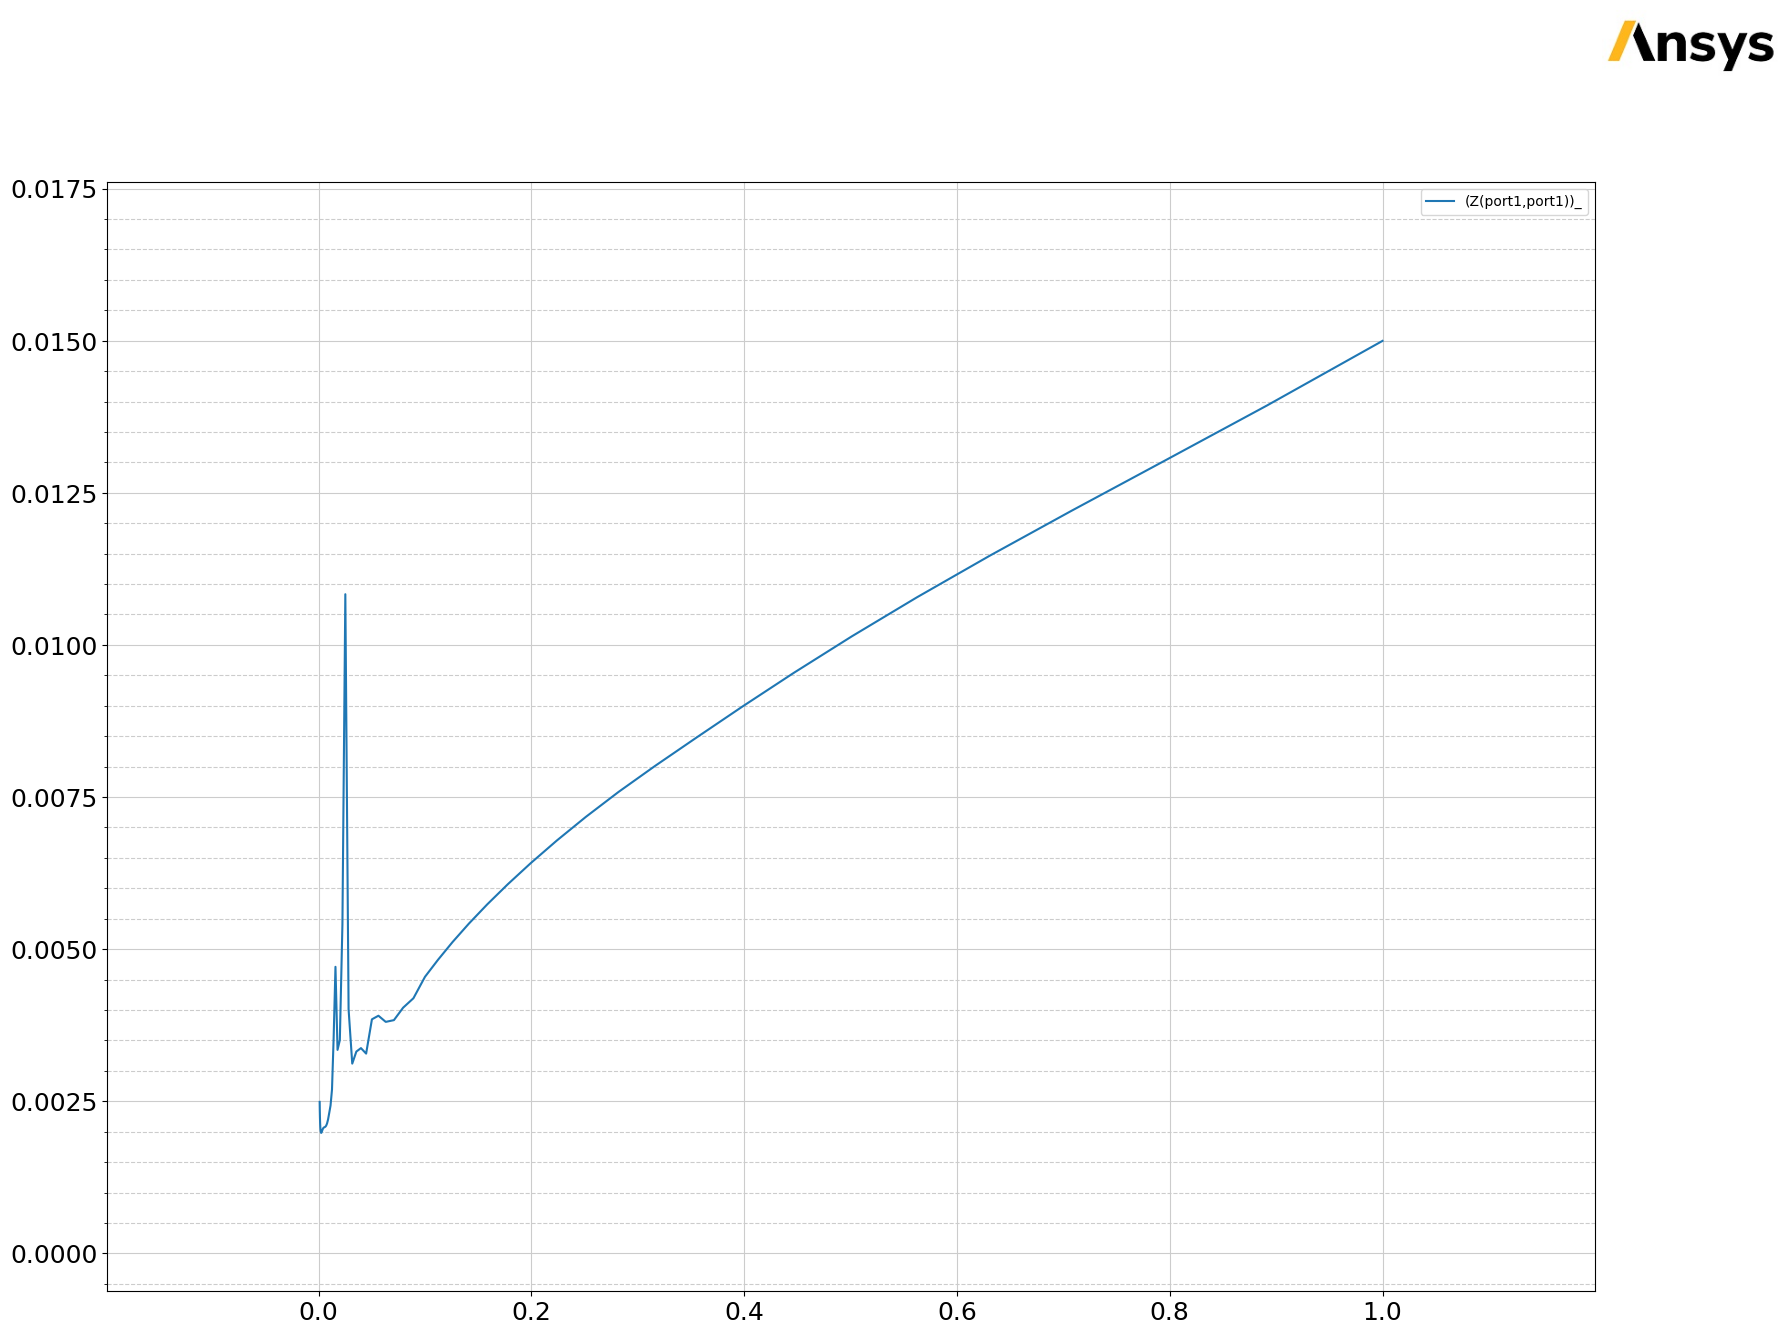

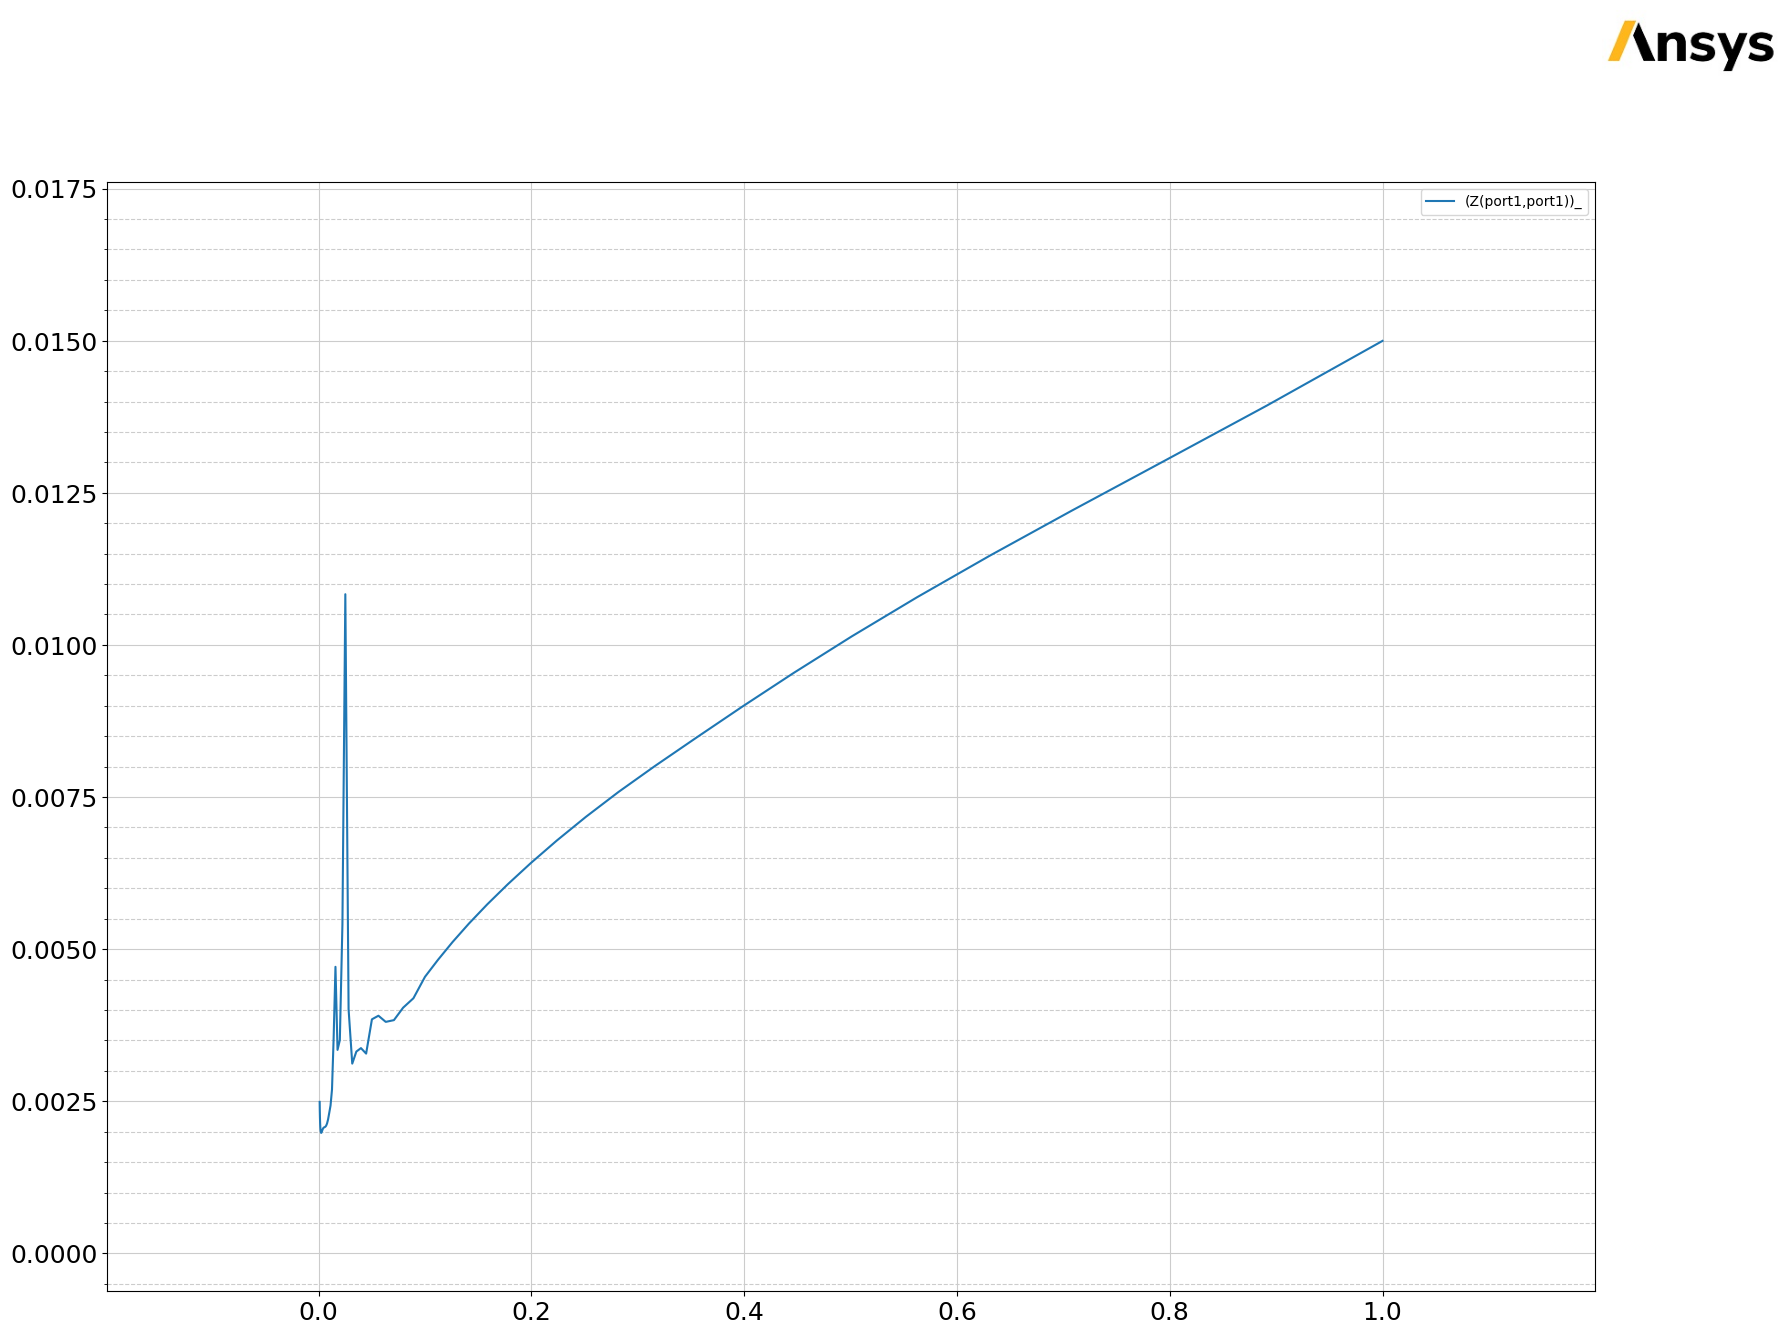

In [17]:
solutions = h3d.post.get_solution_data(expressions="Z(port1,port1)")
solutions.plot()

## Release AEDT

In [18]:
h3d.save_project()
h3d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


INFO:Global:Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Desktop has been released and closed.


INFO:Global:Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [19]:
temp_folder.cleanup()